In [1]:
from dpks.quant_matrix import QuantMatrix
from dpks.classification import Classifier

/home/erikh/dpks/test-venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
qm = QuantMatrix(
    quantification_file="../tests/input_files/data_sepsis.tsv",
    design_matrix_file="../tests/input_files/design_sepsis.tsv")



In [3]:
quantified_data = (
    qm.normalize(
        method="mean",
    )
    .quantify(method="top_n")
)


In [4]:
quantified_data.classify(classifier="xgboost", group_a=1, group_b=2, shap_algorithm="tree", rfe_step = 10, rfe_min_features_to_select=10)
quantified_data.to_df()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

,Protein,FeatureRank,SHAP,TM_P1911_190,TM_P1911_191,TM_P1911_192,TM_P1911_193,TM_P1911_194,TM_P1911_196,TM_P1911_197,...,TM_M2012_190,TM_M2012_191,TM_M2012_192,TM_M2012_196,TM_M2012_197,TM_M2012_198,TM_M2012_199,TM_M2012_200,TM_M2012_202,TM_M2012_203
0,P08603,4.0,0.01384,27.917160,26.200732,25.975755,26.515251,26.439237,26.582008,26.533406,...,26.737434,26.750760,26.771225,26.411031,26.442979,26.512285,26.672639,26.642845,27.336391,26.863229
1,P02671,5.0,0.00000,30.908137,30.832304,30.566479,30.734064,31.100094,30.182586,29.349591,...,30.349528,30.275675,30.712801,28.009665,29.308227,29.345303,29.498104,30.048675,30.576106,29.977439
2,P01042,5.0,0.00000,25.364128,25.234319,25.136428,25.497528,25.650704,26.249714,26.467688,...,26.105971,26.274201,26.120931,26.173301,26.105543,26.162973,26.179120,26.049352,27.268797,26.488321
3,P00450,5.0,0.00000,27.333235,27.645029,27.405650,27.461382,27.365972,27.385601,27.124483,...,27.483159,27.586267,27.557639,27.014641,27.331685,27.714976,27.694537,27.852459,27.574303,27.613746
4,P05156,5.0,0.00000,23.451795,23.645933,23.349888,23.595948,23.729965,24.099617,24.086203,...,23.862439,23.755281,23.964620,23.557492,23.183517,23.507872,23.519149,23.586519,24.327400,23.881691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,P07333,28.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,18.512752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
550,Q06323,29.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,17.150877,18.086225,0.000000,0.000000,19.517408,0.000000,17.283127
551,P16035,51.0,0.00000,0.000000,19.124122,20.428224,19.840918,20.065922,19.232781,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
552,O95633,NaN,NaN,0.000000,0.000000,16.563512,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,18.054630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
df = quantified_data.to_df()
df[df['Protein'] == 'P59665'] 

,Protein,FeatureRank,SHAP,TM_P1911_190,TM_P1911_191,TM_P1911_192,TM_P1911_193,TM_P1911_194,TM_P1911_196,TM_P1911_197,...,TM_M2012_190,TM_M2012_191,TM_M2012_192,TM_M2012_196,TM_M2012_197,TM_M2012_198,TM_M2012_199,TM_M2012_200,TM_M2012_202,TM_M2012_203
232,P59665,1.0,1.244313,24.085189,24.262046,23.991617,24.28774,24.008942,23.486835,23.267737,...,23.391273,23.092243,23.008705,27.251451,26.952818,26.774372,26.392491,26.318986,25.286124,25.5447


In [5]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

def _generate_data_matrices(
     quantitative_data: QuantMatrix, scale: bool
) -> tuple:
    le = LabelEncoder()
    Y = le.fit_transform(quantitative_data.quantitative_data.var["group"].values)
    X = quantitative_data.quantitative_data.X.copy().transpose()
    X = np.nan_to_num(X, copy=True, nan=0.0)
    if scale:
        X = StandardScaler().fit_transform(X)
    return X, Y

scale = True
X, Y = _generate_data_matrices(quantified_data, scale)

In [16]:
clf = Classifier(classifier='xgboost')
clf.cross_validation(X,Y,k_folds=5)
clf.scores

array([0.925     , 0.95      , 0.84615385, 0.58974359, 0.82051282])

This should equals the height of the Feature 232-bar: 1.2443128
This should equals the height of the Feature 148-bar: 0.5501326


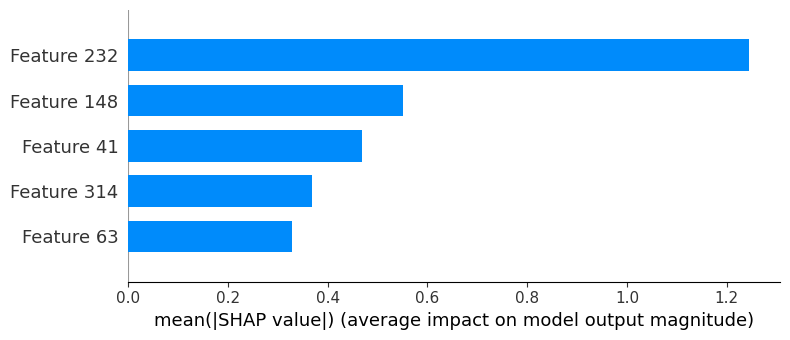

In [11]:
clf.fit(X,Y)
quantified_data.quantitative_data.obs['SHAP']= clf.feature_importances_
print("This should equals the height of the Feature 232-bar:", quantified_data.quantitative_data.obs['SHAP'][232])
print("This should equals the height of the Feature 148-bar:", quantified_data.quantitative_data.obs['SHAP'][148])
import shap

shap.summary_plot(clf.shap_values, X, max_display=5, plot_type='bar')

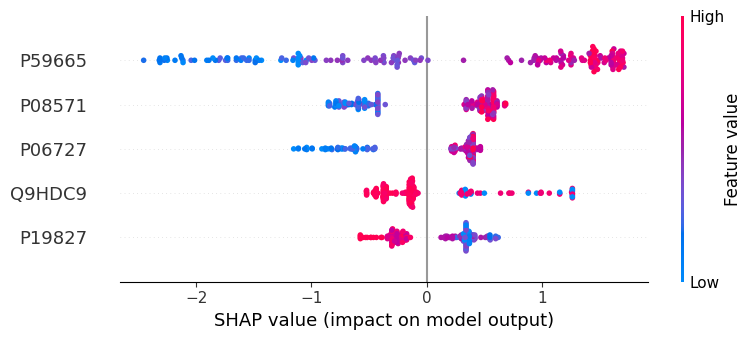

In [15]:
shap.summary_plot(clf.shap_values, X, max_display=5, feature_names = quantified_data.quantitative_data.obs['Protein'])

In [9]:
clf.feature_importances_

array([0.01384006, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02855337, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01801231, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0476414 , 0.        , 0.        ,
       0.15187117, 0.        , 0.        , 0.        , 0.06997503,
       0.        , 0.4690526 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04378975, 0.02780835, 0.0191097 , 0.32817948, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [10]:
min_features_to_select = 5
step=10
selector = clf.recursive_feature_elimination(X,Y,min_features_to_select = min_features_to_select, step=step)
rfe_results = selector.cv_results_

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

Number of selected features: 24


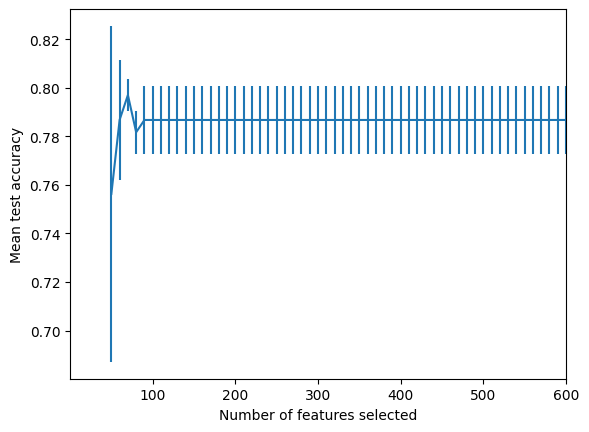

In [11]:
import matplotlib.pyplot as plt

n_scores = len(rfe_results["mean_test_score"])

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores+min_features_to_select),
    rfe_results["mean_test_score"],
    yerr=rfe_results["std_test_score"],
    
)
plt.xticks(plt.xticks()[0][1:], 
           labels=[int(_)*step for _ in plt.xticks()[0][1:]])
plt.xlim([0,60])
plt.show()


In [12]:
quantified_data.quantitative_data.obs['RFE_rank'] = selector.ranking_
